In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
nu = Constant(0.001)
dt = 0.001
k = Constant(dt)
eps = Constant(0.01)
K = Constant(10.0)

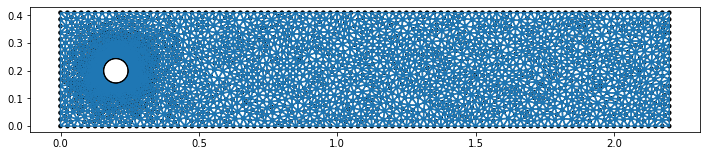

In [3]:
mesh = Mesh("cylinder.msh")
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
plot(mesh, axes=ax1)

In [4]:
mesh = Mesh("cylinder.msh")
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

p = TrialFunction(Q)
q = TestFunction(Q)

u_ = Function(V)
u_n = Function(V)
p_ = Function(Q)
p_n = Function(Q)

U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant((0.0, 0.0))


def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u, p):
    return 2*nu*epsilon(u) - p*Identity(len(u))

x, y = SpatialCoordinate(mesh)

# Define boundary conditions
bcu = [DirichletBC(V, Constant((0,0)), (1, 4)), # top-bottom and cylinder
          DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [DirichletBC(Q, Constant(0), 3)]  # outflow


In [19]:
# Define variational problem for step 1
F1 = dot((u - u_n) / k, v)*dx \
   + dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds \
   - dot(nu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = inner(nabla_grad(p), nabla_grad(q)) * dx
L2 = inner(nabla_grad(p_n), nabla_grad(q)) * dx \
    - (1/k) * inner(div(u_), q) * dx


# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

A1 = assemble(a1, bcs=bcu)
A2 = assemble(a2, bcs=bcp)
A3 = assemble(a3)
b1 = assemble(L1, bcs=bcu)
b2 = assemble(L2, bcs=bcp)
b3 = assemble(L3)

# Define linear problems
prob1 = LinearVariationalProblem(a1, L1, u_, bcs=bcu)
prob2 = LinearVariationalProblem(a2, L2, p_, bcs=bcp)
prob3 = LinearVariationalProblem(a3, L3, u_)

# Define solvers
solve1 = LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'bicg'})  
solve2 = LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'bicg', 'pc_type': 'gamg'})  
solve3 = LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})  

In [30]:
# Time loop
t = 0.0
t_end = 5.

print("Beginning time loop...")

while t < t_end :
    
    solve(A1, u_, b1, solver_parameters={"snes_type": "newtonls",
                                 "ksp_type" : "gmres",
                                 "pc_type" : "sor"})
    solve(A2, p_, b2, solver_parameters={"snes_type": "newtonls",
                                 "ksp_type" : "gmres",
                                 "pc_type" : "gamg"})
    solve(A3, u_, b3, solver_parameters={"snes_type": "newtonls",
                                 "ksp_type" : "cg",
                                 "pc_type" : "sor"})
    
    t += dt

    # update solutions
    u_n.assign(u_)
    p_n.assign(p_)

    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Beginning time loop...


ConvergenceError: ('LinearSolver failed to converge after %d iterations with reason: %s', 0, 'DIVERGED_NANORINF')

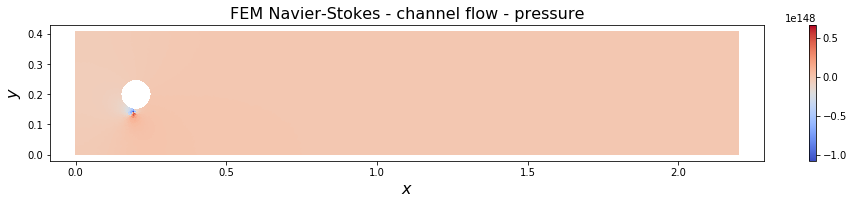

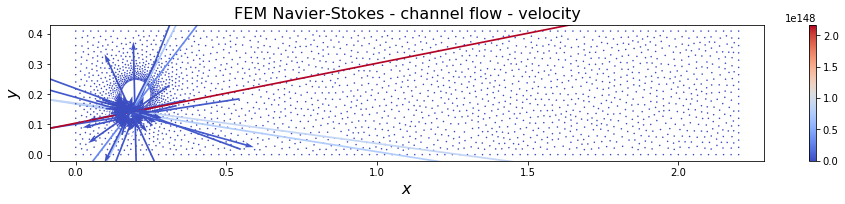

In [28]:
fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
plot(p_,axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
plot(u_,axes=ax1)
ax1.axis('equal');

In [ ]:
mesh = Mesh('lowres_cylinder.msh')
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

p = TrialFunction(Q)
q = TestFunction(Q)

u_ = Function(V)
u_n = Function(V)
p_ = Function(Q)
p_n = Function(Q)

U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant((0.0, 0.0))


def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u, p):
    return 2*nu*epsilon(u) - p*Identity(len(u))

x, y = SpatialCoordinate(mesh)

# Define boundary conditions
bcu = [DirichletBC(V, Constant((0,0)), (1, 4)), # top-bottom and cylinder
          DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [DirichletBC(Q, Constant(0), 3)]  # outflow

# Define function space for system of concentrations
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1, P1, P1])
H = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(H)

# Define functions for velocity and concentrations
c = Function(H)
c_n = Function(H)

# Split system functions to access components
c_1, c_2, c_3 = split(c)
c_n1, c_n2, c_n3 = split(c_n)

f_1 = conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0)
f_2 = conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0)
f_3 = Constant(0.0)

In [13]:
# Define variational problem for step 1
F1 = dot((u - u_n) / k, v) * dx \
   + dot(dot(u_n, nabla_grad(u_n)), v) * dx \
   + inner(sigma(U, p_n), epsilon(v)) * dx \
   + dot(p_n * n, v) * ds - dot(nu*nabla_grad(U) * n, v) * ds \
   - dot(f, v) * dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q)) * dx
L2 = dot(nabla_grad(p_n), nabla_grad(q)) * dx - (1 / k) * div(u_) * q * dx

# Define variational problem for step 3
a3 = dot(u, v) * dx
L3 = dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx

# Define variational problem
F = ((c_1 - c_n1) / k) * v_1 * dx \
    + ((c_2 - c_n2) / k) * v_2 * dx \
    + ((c_3 - c_n3) / k) * v_3 * dx
F += dot(u_, grad(c_1)) * v_1 * dx \
    + dot(u_, grad(c_2)) * v_2 * dx \
    + dot(u_, grad(c_3)) * v_3 * dx
F += eps * dot(grad(c_1), grad(v_1)) * dx \
    + eps * dot(grad(c_2), grad(v_2)) * dx \
    + eps * dot(grad(c_3), grad(v_3)) * dx
F += K * c_1 * c_2 * v_1 * dx  \
    + K * c_1 * c_2 * v_2 * dx  \
    - K * c_1 * c_2 * v_3 * dx \
    + K * c_3 * v_3 * dx
F += - f_1 * v_1 * dx \
    - f_2 * v_2 * dx \
    - f_3 * v_3 * dx

# Define linear problems
prob1 = LinearVariationalProblem(a1, L1, u_, bcs=bcu)
prob2 = LinearVariationalProblem(a2, L2, p_, bcs=bcp)
prob3 = LinearVariationalProblem(a3, L3, u_)
prob4 = NonlinearVariationalProblem(F, c)

# Define solvers
solve1 = LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'bcgs', 'pc_type': 'sor'})  
solve2 = LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})  
solve4 = NonlinearVariationalSolver(prob4)

NameError: name 'c_1' is not defined

In [ ]:
# Time loop
t = 0.0
t_end = 5.0

print("Beginning time loop...")

while t < t_end :
    t += dt
    
    solve1.solve()
    solve2.solve()
    solve3.solve()

    # update solutions
    u_n.assign(u_)
    p_n.assign(p_)
    
    solve4.solve()
    _c_1, _c_2, _c_3 = c.split()
    c_n.assign(c)

    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

In [ ]:
fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
plot(_c_1, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
plot(_c_2, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
plot(_c_3, axes=ax1)

In [ ]:
Mesh?

In [12]:
solve?